# Bullying recognition from Tweeter Corpus, build on recent events

## Imports 

In [61]:
# Load libraries
import pandas as pd 
from pandas import DataFrame
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree 
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import requests
from geopy.geocoders import Nominatim
from geopy.distance import vincenty
import json
import difflib
import copy
from pprint import pprint
import csv
import numpy as np
import re
import csv
import json
import xlwt
import re
import warnings
warnings.filterwarnings('ignore')

# 1. Program Execution

Before starting data execution in Section one, all functions in section 2-3 should be run 

## 1.1 Data Preprocessing

In [72]:
# 1 Parse File with tweets json
TweetsJsonArray=ParseFileIntoJson('pythontest1.json')

In [ ]:
book = xlwt.Workbook()
sheet1 = book.add_sheet("Sheet1",cell_overwrite_ok=True)
book.save("TweetCorpusExel.xls")
# 2 Pocess Json, Write in Exel
Processing(TweetsJsonArray)

In [ ]:
# 3 Sort Tweet for repitions retrieval and retweeters gathering
SortExel('TweetCorpusExel.xls','TweetCorpusExel1.xls')
# 4 Group similar tweets
DeleteRepititions('TweetCorpusExel1.xls','TweetCorpusExel2.xls')

## 1.2 Mashine learning 

In [79]:
shapeData('TweetCorpusExelMC.xlsx')#passing manually classified set


For further implementation refer Mashine learning part of the current project 
[Part4](#4)

## 1.2 Classifying the rest of the corpus   

After Training the classifier, 
we can use the it for predicting if the class is bulllying or not for the rest of the corpus

In [80]:
#TweetCorpusExelWholeCorpus3 - preprocessed file
writePredictionsToFile('TweetCorpusExelWholeCorpus3.xls','TweetCorpusExelWholeCorpus4.xls')


After writing the predictions, location analysis could be conducted. For that refer [Part5](#5)

# 2. Service Functions

### The snippet of code below reads the file, which containes the tweets in json fromat, gatherered by streiming the tweeter


In [3]:
#Reading the file
def ParseFileIntoJson(file):
    TweetsJsonArray = []
    TweetsJsonArray2 = []
    myArray = []
    i=0
    with open(file) as f:
        for line in f:
            i=i+1
            line2=line.lstrip()        
            if line2!='':                
                TweetsJsonArray.append(json.loads(line2))            
    return TweetsJsonArray

## 2.2 Loading Dictionaries

In [7]:
collectivenouns=[]
pronouns=[]
offensiveWords = dict() 
xl = pd.ExcelFile("Dictionary.xlsx")

df = xl.parse("OffensiveWords")
l = len(df)
for i in range(l)[1:]:
    offensiveWords[(df['Word'][i]).lower()]=df['Weight'][i]
    
df = xl.parse("Nouns")
l = len(df)
for i in range(l)[1:]:
    collectivenouns.append((df['Collective Nouns'][i]).lower()) 
    
df = xl.parse("Pronouns")
l = len(df)
for i in range(l)[1:]:
    pronouns.append(df['Personal Pronouns'][i])

## 2.3. Functions

### 2. The code snippet below contains the functions, used accross the project, such as the Offensiveness level calculation, two tweets similarity calculation 

In [81]:
#Counting the similarity persent of two texts

import difflib
def similar(a, b):
    return difflib.SequenceMatcher(None, a, b).ratio()

#Calculating the offinsiveness level

def offensiveness_weight(TweetText):        
        templist = TweetText.split()
        offensiveWordsList=list(offensiveWords.keys())
        temp = set(offensiveWordsList).intersection(templist)
        my_list = list(temp)        
        final = 0
        result=0
        
        if len(my_list)!=0:
            for word in my_list:                
                final = float(final) + float(offensiveWords[word])        
            result = final / len(my_list)
        return result
    
#Identifying the existance of the words

def wordpresence(TweetText,wordlist):
    templist1= TweetText.split()    
    temp1 = set(wordlist).intersection(templist1) 
    my_list1 = list(temp1)    
    if len(my_list1)!=0:
        return 1
    else:
        return 0
# Counting the level of offensiveness 
def offensive_level(TweetText):
    
    nounsExistance = wordpresence(TweetText,collectivenouns)    
    pronounsExistance = wordpresence(TweetText,pronouns)
    
    if offensiveness_weight(TweetText) > 0 and (wordpresence or pronounsExistance) :    
        return (offensiveness_weight(TweetText) + 1)/6 * 100
    else:
        return (offensiveness_weight(TweetText))/6 * 100
    
#Count how many words from the wordlist parameter are in tweet
def WordCount(TweetText,wordlist):
    templist1= TweetText.split()    
    temp1 = set(wordlist).intersection(templist1) 
    my_list1 = list(temp1)     
    return len(my_list1)
#Get the coordinates by textual name of the location (by address)
def GeoLocationByTweetLocation(location):        
    try:
        geolocator = Nominatim()    
        location = geolocator.geocode(location)
        return (str(location.latitude)+";" +str(location.longitude))
    except :
        return ""
#Find the distance between location in miles      
def distance(u,v):
    return vincenty(u, v).miles
#Find the adress of the loction by coordinates
def getLocationByCoordinates(c):
    geolocator = Nominatim()
    location = geolocator.reverse(c)
    return location
def writePredictionsToFile(file1,file2):
    df = pd.read_excel(file1, sheetname='Sheet1')
    writer = pd.ExcelWriter(file2)    
    m = len(df)   
    for i in range(m):       
        a= df['Offensiveness Weight'][i]
        b=df['Offensiveness Level'][i]
        c = df['Sentimental Analysis'][i]
        df['Class'][i]=dt.predict([a,b,c]) 
       
    df.to_excel(writer,'Sheet1',index=False)
    writer.save()
    writer.close()

## 2.4 Third Party Libriries

In [6]:
import requests
# Request to third party sentimental analysis library
def SentimentalAnalysis(tweet):
    r = requests.post("http://text-processing.com/api/sentiment/", data={'text': tweet})
    label= r.json()['label']
    if label =='neutral':
        return 0
    elif label=='pos':
        return 1
    else :        
        return 2          

# 3. Preprocessing

In [10]:
#Preprocessing the tweets and writing the content to the exel for Manual Analysis
def Processing(TweetsJsonArray):
    geolocator = Nominatim()
    num=1;
    book = xlwt.Workbook()
    sheet1 = book.add_sheet("Sheet1",cell_overwrite_ok=True)
    row = sheet1.row(0)
    row.write(0, 'Text')  
    row.write(1, 'Description')    
    row.write(2, 'Offensiveness Weight')
    row.write(3, 'Offensiveness Level')
    row.write(4, 'Offensive Words Amount')
    row.write(5,'Sentimental Analysis')
    row.write(6,'Class')
    row.write(7,'Geo_Location')
    row =1
    for tweet in TweetsJsonArray:      
        
        if tweet['lang']=="en":            
            row = sheet1.row(num)             
            text=''
            if 'extended_tweet' in tweet:
                text=tweet['extended_tweet']['full_text']
            elif 'retweeted_status' in tweet:
                if 'extended_tweet' in tweet['retweeted_status']:
                    text=tweet['retweeted_status']['extended_tweet']['full_text']
                else:
                    text=tweet['retweeted_status']['text']
            else:
                text=tweet['text']
            text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
            names = tweet['user']['name']
            description = tweet['user']['description']
            PERMITTED_CHARS = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_- "
            text = "".join(c for c in text if c in PERMITTED_CHARS)
            text=text.lower()
            text=text.strip()
            names="".join(c for c in names if c in PERMITTED_CHARS)
            description="".join(c for c in description if c in PERMITTED_CHARS) if description!= None else ''
            description=description.lower()
            description=description.strip() # delete beginning and ending whitespaces    
            location=""
            if 'location' in tweet['user']:
                if tweet['user']['location']!='nan' and tweet['user']['location']!='':
                    location=GeoLocationByTweetLocation(tweet['user']['location'])              
            row.write(0, text)           
            row.write(1, description)               
            row.write(7, location)
            num=num+1

    book.save("TweetCorpusExel.xls")

### 3.1 Sort the tweets in the file

In [52]:
#Sort exel file by text
def SortExel(fileIn,fileOut):
    xl = pd.ExcelFile(fileIn)
    df = xl.parse("Sheet1")
    df = df.sort_values(by="Text")
    writer = pd.ExcelWriter(fileOut)
    df.to_excel(writer,'Sheet1',index=False)
    writer.save()
    writer.close()

### 3.2 Delete repeating tweets

In [53]:
#Group the tweets with the same text
def DeleteRepititions(fileIn,fileOut):
    df = pd.read_excel(fileIn, sheetname='Sheet1')
    writer = pd.ExcelWriter(fileOut)
    currentrow=0 #first raw with unique tweet   
    tweet=str(df['Text'][currentrow])
    l = len(df)
    num=0    
    for i in range(l)[1:]:         
        num=num+1
        if df['Text'][i]==tweet or similar(df['Text'][i],tweet)>0.8:        
            if len(df['Text'][i])>len(tweet):
                df['Text'][currentrow]=df['Text'][i]             
            df['Text'][i]=''
            if str(df['Geo_Location'][i])!='nan':
                if str(df['Geo_Location'][currentrow])!='nan':
                    df['Geo_Location'][currentrow]=str(df['Geo_Location'][currentrow])+"&"+str(df['Geo_Location'][i])
                else :
                    df['Geo_Location'][currentrow]=str(df['Geo_Location'][i])
            if str(df['Description'][i])!='nan':            
                    df['Text'][currentrow]=str(df['Text'][currentrow])+" \n <::> "+str(df['Description'][i])
        else:
            if str(df['Description'][currentrow])!='nan':
                df['Text'][currentrow]=str(df['Text'][currentrow])+" \n <::> "+str(df['Description'][currentrow])
            tweet=str(df['Text'][currentrow])
            df['Offensiveness Weight'][currentrow]=offensiveness_weight(tweet)        
            df['Offensiveness Level'][currentrow]=offensive_level(tweet) 
            df['Offensive Words Amount'][currentrow]=WordCount(tweet,offensiveWords)
            df['Sentimental Analysis'][currentrow]=SentimentalAnalysis(tweet)                                    
            currentrow=i  
            tweet=str(df['Text'][currentrow])
   
    df = df[df.Text != '']   
    df.to_excel(writer,'Sheet1',index=False)
    writer.save()
    writer.close()


## 3.3. Preprocess data for mashine learning

In [34]:
#prepare data for mashine learning
def shapeData(file):
    df = pd.read_excel(file, sheetname='Sheet1')
    writer = pd.ExcelWriter('TweetCorpusExelML.xlsx')
    del df['Description']
    del df['Geo_Location']
    del df['Text']
    del df['Offensive Words Amount']
    df.to_excel(writer,'Sheet1',index=False)
    writer.save()
    writer.close()

# 4. Maschine Learning

<a id='4'></a>

## 4.1 Build Models

In [42]:
dataset = pd.read_excel(open('TweetCorpusExelML.xlsx','rb'), sheetname='Sheet1')
print(dataset.head(20))

    Offensiveness Weight  Offensiveness Level  Sentimental Analysis  Class
0                    0.0             0.000000                     2      0
1                    1.5            41.666667                     0      1
2                    1.0            33.333333                     0      1
3                    0.0             0.000000                     0      0
4                    1.5            41.666667                     0      1
5                    0.0             0.000000                     0      0
6                    0.0             0.000000                     0      0
7                    0.0             0.000000                     1      0
8                    0.0             0.000000                     0      0
9                    0.0             0.000000                     0      0
10                   0.0             0.000000                     0      0
11                   2.5            58.333333                     0      1
12                   3.0 

In [43]:
print(dataset.shape)
print(dataset.describe())
print(dataset.groupby('Class').size())

(332, 4)
       Offensiveness Weight  Offensiveness Level  Sentimental Analysis  \
count            332.000000           332.000000            332.000000   
mean               1.051205            25.451807              0.397590   
std                1.388890            30.204781              0.719848   
min                0.000000             0.000000              0.000000   
25%                0.000000             0.000000              0.000000   
50%                0.000000             0.000000              0.000000   
75%                2.000000            50.000000              1.000000   
max                5.000000           100.000000              2.000000   

            Class  
count  332.000000  
mean     0.460843  
std      0.499217  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      1.000000  
Class
0    179
1    153
dtype: int64


In [44]:
array = dataset.values
X = array[:,0:3]
Y = array[:,3]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [45]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'


In [46]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.826068 (0.066301)
LDA: 0.826068 (0.066301)
KNN: 0.811111 (0.075453)
CART: 0.814672 (0.069370)
NB: 0.818661 (0.069617)
SVM: 0.822222 (0.063864)


## 4.2 Prediction Section

In [48]:
df1 = pd.read_excel(open('TweetCorpusExelML.xlsx','rb'), sheetname='Sheet1')
features = list(df1.columns[:3])
print("* features:", features, sep="\n")
y = df1["Class"]
X = df1[features]
dt = LogisticRegression()
dt.fit(X, y)

* features:
['Offensiveness Weight', 'Offensiveness Level', 'Sentimental Analysis']


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [49]:
dt = LogisticRegression()
dt.fit(X_train, Y_train)
predictions = dt.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.805970149254
[[28  7]
 [ 6 26]]
             precision    recall  f1-score   support

        0.0       0.82      0.80      0.81        35
        1.0       0.79      0.81      0.80        32

avg / total       0.81      0.81      0.81        67



### Demonstartion

In [ ]:
TweetText = "Book is bad"
y = offensive_level(TweetText)
x = offensiveness_weight(TweetText)
z = SentimentalAnalysis(TweetText)
print (x)
print  (y)
print (z)
print(dt.predict([x,y,z]))

## 5 Location

<a id='5'></a>

#### Reading the geo locations into the array 

In [65]:
df = pd.read_excel('TweetCorpusExelWholeCorpus4.xls', sheetname='Sheet1')
df = df[df.Class== 1]  
df = df[df.Geo_Location!=''] 
df = df[df.Geo_Location!='nan'] 
location=df['Geo_Location']
LLTuplesLocationsArray=list()
i=0
LLTuplesLocationsArray=list()
lats1=list()
lons1=list()
for tweetLoc in location:
    if str(tweetLoc)!="nan":
        tweetLocArr=tweetLoc.split('&')        
        for t in tweetLocArr:
            ll=t.split(';')
            LLTuplesLocationsArray.append([float(ll[0]),float(ll[1])])
            lats1.append(float(ll[0]))
            lons1.append(float(ll[1]))
X = np.array(LLTuplesLocationsArray,float)

### Performing Clustering 

In [66]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import numpy as np

print (X.shape) 
plt.scatter(X[:,0], X[:,1])
Z = linkage(X,metric=distance)# - distance : miles between two spots

(1459, 2)


#### Counting Cophenetic Correlation Coefficient 

In [67]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
# Cophenetic Correlation Coefficient - compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering
c, coph_dists = cophenet(Z, pdist(X, distance))
c

0.77572031731131097

####  Printing the dendogram

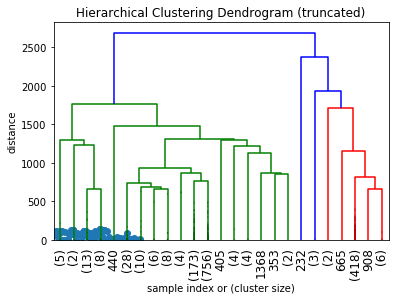

In [68]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [69]:
#Repeating the steps of agglomeration for capturing the content of the clusters on each iteration
X2 = X.tolist()
X3=list(map(lambda x:[x], X2))
j=0
for c in Z:    
    X3.append(X3[int(c[0])])
    ml= copy.copy(X3[len(X3)-1])
    ml.extend(X3[int(c[1])])
    X3[len(X3)-1]=copy.copy(ml)

In [70]:
#Saving the results of the clusterization into the exel file for manual analysis
book = xlwt.Workbook()
sheet1 = book.add_sheet("Sheet1",cell_overwrite_ok=True)
row = sheet1.row(0)
row.write(0, 'first cluster')
row.write(1, 'second cluster')
row.write(2, 'distance')
row.write(3, 'Number of samples')
row.write(4, 'coordinates')
row.write(5, 'iteration')
i=1
for c in Z:
    row = sheet1.row(i)
    row.write(0, c[0])
    row.write(1, c[1])
    row.write(2, c[2])
    row.write(3, c[3])
    row.write(4, ''.join(map(str, X3[1347+i])))
    row.write(5, i)
    i=i+1
    
book.save("Clusters.xls")

In [71]:
print(Z[691])    
print(getLocationByCoordinates('44.933143,7.540121'))#515

[ 1333.  2149.     0.   500.]
57, Via Roma, None, TO, PIE, Italia


In [42]:
print (Z[1178]) 
print(getLocationByCoordinates('40.0757384,-74.4041622'))
print(getLocationByCoordinates('42.36050195,-71.2009040042125'))


[ 2501.         2517.           94.0278165    77.       ]
Jackson Township, Ocean County, New Jersey, United States of America
New England Preferred Properties, 362, Watertown Street, Bemis, Watertown, Middlesex, Massachusetts, 02458, United States of America


In [43]:
print (Z[1080])
print (getLocationByCoordinates('52.7954791, -0.540240286617432'))
print (getLocationByCoordinates('52.478218, -1.8930052'))

[ 1519.          2426.            44.08257415   115.        ]
Overgate Road, Swayfield CP, South Kesteven, Lincolnshire, East Midlands, England, UK
What are you searching for?, Moor Street, Digbeth, Birmingham, West Midlands Combined Authority, West Midlands, England, B5, UK


In [44]:
print (Z[1078])                              
print(getLocationByCoordinates('54.666667, -1.75'))

[  594.          2418.            43.69330084   111.        ]
Sloshes Lane, Phoenix Row, County Durham, North East England, England, UK


In [45]:
print (Z[1161])
print(getLocationByCoordinates('40.7317855, -73.4481361974341'))
print(Z[887])
print (getLocationByCoordinates('39.7837304, -100.4458825'))#51 - 464
print (Z[1024])  
print(getLocationByCoordinates('22.3511148, 78.6677428'))

[ 2473.         2476.           86.3432732   139.       ]
Waverly Place, Farmingdale, Nassau County, New York, 11735, United States of America
[ 1322.  2234.     0.    51.]
County Road 491, Kanona, Decatur County, Kansas, United States of America
[ 2360.         2367.           22.4008668    40.       ]
SH19, Tamia, Chhindwāra, Chhindwara, Madhya Pradesh, 480559, India


In [50]:
import plotly 
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='mariamam', api_key='2Fg0f8nthJw3ZimaQ54i')
# Learn about API authentication here: https://plot.ly/python/getting-started
# Find your api_key here: https://plot.ly/settings/api
data = [go.Bar(
            x=['Italia','England, UK','New York, United States of America','Kansas, United States of America'],
            y=[501, 226,139,51]
    )]

py.iplot(data, filename='basic-bar')

In [288]:
def drawArea(coordinatesArray):
    lons=list()
    lats=list()
    for c in coordinatesArray:
        lats.append(c[0])
        lons.append(c[1])    
    m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180,resolution='c') 
    x, y = m(lons,lats)
    m.drawmapboundary(fill_color='#99ffff')
    m.fillcontinents(color='#cc9966',lake_color='#99ffff')
    m.scatter(x,y,3,marker='o',color='k')
    plt.title('Locations of %s ARGO floats',fontsize=12)
    plt.figure(figsize=(100,100))
    plt.show()

### Diagram Analysis 

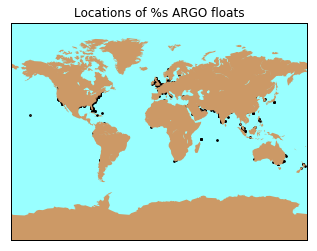

In [82]:
from netCDF4 import Dataset, num2date
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180,resolution='c') 
x, y = m(lons1,lats1)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
m.scatter(x,y,3,marker='o',color='k')
plt.title('Locations of %s ARGO floats',fontsize=12)
plt.figure(figsize=(100,100))
plt.show()